In [2]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, auc, roc_curve
from torch.utils.data import (
    Dataset,
    DataLoader
)
from sklearn.preprocessing import LabelBinarizer
import timm
from tqdm.cli import tqdm
import warnings
warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/jainvaibhav/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_no = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/no') #10000 each
train_sphere = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/sphere')
train_vort = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/vort')

val_no = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/no') 
val_sphere = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/sphere')
val_vort = os.listdir('/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/vort')

In [4]:
df_no = pd.DataFrame(columns=['path', 'class'])
df_no['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/no/' + pd.Series(train_no)
df_no['class'] = 0

df_sphere = pd.DataFrame(columns=['path', 'class'])
df_sphere['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/sphere/' + pd.Series(train_sphere)
df_sphere['class'] = 1

df_vort = pd.DataFrame(columns=['path', 'class'])
df_vort['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/train/vort/' + pd.Series(train_vort)
df_vort['class'] = 2

df_val_no = pd.DataFrame(columns=['path', 'class'])
df_val_no['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/no/' + pd.Series(val_no)
df_val_no['class'] = 0

df_val_sphere = pd.DataFrame(columns=['path', 'class'])
df_val_sphere['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/sphere/' + pd.Series(val_sphere)
df_val_sphere['class'] = 1

df_val_vort = pd.DataFrame(columns=['path', 'class'])
df_val_vort['path'] = '/home/jainvaibhav/Vaibhav_Jain/gsoc/dataset/val/vort/' + pd.Series(val_vort)
df_val_vort['class'] = 2

In [5]:
combined_df = pd.concat([df_no, df_sphere, df_vort], ignore_index=True)
combined_val_df = pd.concat([df_val_no, df_val_sphere, df_val_vort ], ignore_index = True)

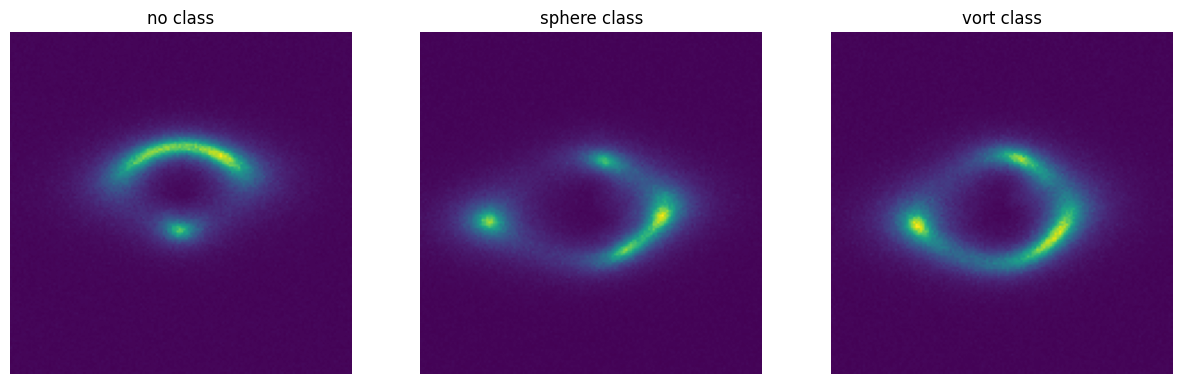

In [6]:
img_no = np.load(df_no['path'][0])
img_sp = np.load(df_sphere['path'][0])
img_vort = np.load(df_vort['path'][0])

fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_no[0])  # Assuming grayscale image, adjust cmap as needed
plt.title('no class')
plt.axis('off')  # Turn off axis

plt.subplot(1, 3, 2)
plt.imshow(img_sp[0])  # Assuming grayscale image, adjust cmap as needed
plt.title('sphere class')
plt.axis('off')  # Turn off axis

plt.subplot(1, 3, 3)
plt.imshow(img_vort[0])  # Assuming grayscale image, adjust cmap as needed
plt.title('vort class')
plt.axis('off')  # Turn off axis

plt.show()

In [7]:
class train_config:
    BATCH_SIZE = 16
    EPOCHS = 15
    criterion = nn.CrossEntropyLoss()

In [8]:
class Train_Dataset(Dataset):
    def __init__(self, dataset):
        """
        Args:
            list_images (list): List of all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_images_path, self.list_labels = dataset['path'], dataset['class']

    def __len__(self):
        return len(self.list_images_path)

    def __getitem__(self, idx):
        image = np.load(self.list_images_path.iloc[idx])
        img_labels = self.list_labels.iloc[idx]
        return torch.tensor(image), torch.tensor(img_labels)

In [9]:
class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = timm.create_model('resnet50', pretrained=True, in_chans=1, num_classes = num_classes)

    def forward(self, x):
        return self.model(x)

In [29]:
def plot_multiclass_roc_curve(y_test, y_pred, classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Convert y_test and y_pred to numpy arrays
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    for i in range(len(classes)):
        # Compute ROC curve and ROC area for each class
        fpr[i], tpr[i], _ = roc_curve(y_test == classes[i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
def training(dataset, val_dataset, train_config):
    train_dl = DataLoader(dataset,
                    batch_size=train_config.BATCH_SIZE,
                    shuffle=True)
    
    val_dl = DataLoader(val_dataset,
                    batch_size = train_config.BATCH_SIZE,
                    shuffle=False)
    
    EPOCHS = train_config.EPOCHS
    nu_classes = 3
    model = Model(nu_classes).to(DEVICE).double()
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)
    best_metric = np.inf
    for epoch in range(EPOCHS):
        running_loss = 0.0
        model.train()
        for element in tqdm(train_dl, total = len(train_dl),desc="Training"):
            optimizer.zero_grad()
            image, label = element
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            pred = model(image)
            loss = train_config.criterion(pred, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
                    
        model.eval()
        val_loss=0
        for element in tqdm(val_dl, total = len(val_dl),desc="Validating"):
            with torch.no_grad():
                image, label = element
                image = image.to(DEVICE)
                label = label.to(DEVICE)
                pred = model(image)
                val_loss += train_config.criterion(pred, label).item()

        scheduler.step(val_loss/len(val_dl)) 
        print(f'EPOCH: {epoch+1} TRAIN LOSS: {(running_loss/len(train_dl)):.4f}  VAL LOSS: {(val_loss/len(val_dl)):.4f}')
        if best_metric > val_loss/len(val_dl):
            best_metric = val_loss/len(val_dl)
            print('best model saved')
            torch.save(model.state_dict(), 'model_weights.pth')
    return best_metric

In [12]:
train_ds = Train_Dataset(dataset = combined_df)
val_ds = Train_Dataset(dataset = combined_val_df)

In [12]:
score = training(train_ds, val_ds, train_config)

Validating: 100%|██████████| 469/469 [00:09<00:00, 48.32it/s]


EPOCH: 1 TRAIN LOSS: 1.0939  VAL LOSS: 1.6931
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.18it/s]


EPOCH: 2 TRAIN LOSS: 0.6746  VAL LOSS: 0.4345
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.28it/s]


EPOCH: 3 TRAIN LOSS: 0.3676  VAL LOSS: 0.3659
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.30it/s]


EPOCH: 4 TRAIN LOSS: 0.2813  VAL LOSS: 0.2620
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.41it/s]


EPOCH: 5 TRAIN LOSS: 0.2386  VAL LOSS: 0.2633


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]


EPOCH: 6 TRAIN LOSS: 0.2073  VAL LOSS: 0.2534
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.14it/s]


EPOCH: 7 TRAIN LOSS: 0.1897  VAL LOSS: 0.2537


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.30it/s]


EPOCH: 8 TRAIN LOSS: 0.1625  VAL LOSS: 0.2631


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.35it/s]


EPOCH: 9 TRAIN LOSS: 0.1536  VAL LOSS: 0.2163
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.63it/s]


EPOCH: 10 TRAIN LOSS: 0.1361  VAL LOSS: 0.2101
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.61it/s]


EPOCH: 11 TRAIN LOSS: 0.1231  VAL LOSS: 0.2243


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.58it/s]


EPOCH: 12 TRAIN LOSS: 0.1171  VAL LOSS: 0.3031


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.65it/s]


EPOCH: 13 TRAIN LOSS: 0.1068  VAL LOSS: 0.2108


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.46it/s]


EPOCH: 14 TRAIN LOSS: 0.0444  VAL LOSS: 0.1861
best model saved


Validating: 100%|██████████| 469/469 [00:09<00:00, 48.56it/s]

EPOCH: 15 TRAIN LOSS: 0.0185  VAL LOSS: 0.2155


Validating: 100%|██████████| 469/469 [00:10<00:00, 46.14it/s]


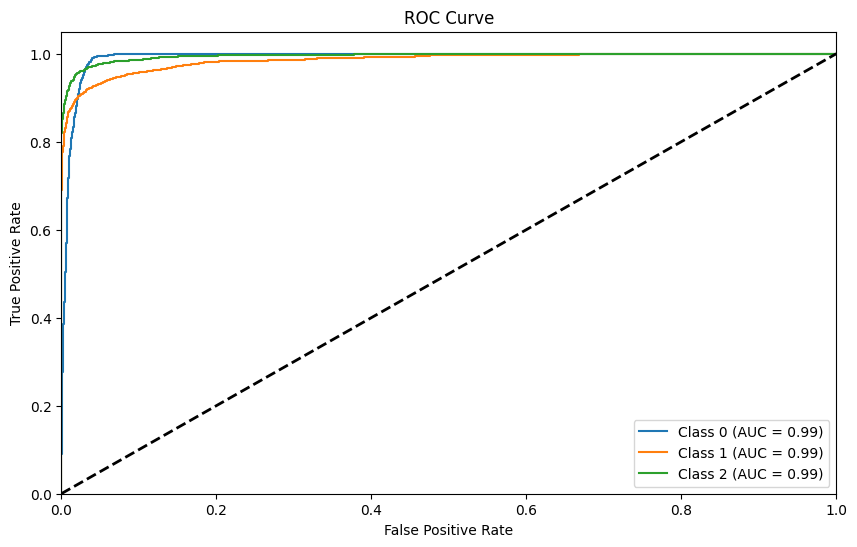

Average Roc AUC Score:  0.9906023733333335


In [32]:
model = Model(3).to(DEVICE).double()
model.load_state_dict(torch.load("/home/jainvaibhav/Vaibhav_Jain/gsoc/model_weights.pth"))
true_labels = []
predicted = []          
model.eval()
softmax = nn.Softmax(dim=1)  # Softmax activation
val_dl = DataLoader(val_ds,
                    batch_size = 16)

val_loss=0
for element in tqdm(val_dl, total = len(val_dl),desc="Validating"):
    with torch.no_grad():
        image, label = element
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        pred = model(image)
        val_loss += train_config.criterion(pred, label).item()
        pred = softmax(pred)
        true_labels.extend(label.cpu().numpy())
        predicted.extend(pred.cpu().detach().numpy())

roc_auc  = roc_auc_score(true_labels, predicted, multi_class='ovr', average=None)
plot_multiclass_roc_curve(true_labels, predicted,[0, 1, 2])
print('Average Roc AUC Score: ',roc_auc.mean())